In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/car-object-detection/data/sample_submission.csv
/kaggle/input/car-object-detection/data/train_solution_bounding_boxes (1).csv
/kaggle/input/car-object-detection/data/testing_images/vid_5_26420.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_31520.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_29420.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_31720.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_26560.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_27840.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_28560.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_28360.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_25240.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_29560.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_29020.jpg
/kaggle/input/car-object-detection/data/testing_images/vid_5_30720.jpg
/kaggle/

In [14]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Darknet repo klonlama
!git clone https://github.com/AlexeyAB/darknet

# Darknet dizinine geçiş
%cd darknet

# Makefile ayarlarını düzenleme (GPU ve OpenCV devre dışı, CPU kullanımı)
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=1/GPU=0/' Makefile
!sed -i 's/CUDNN=1/CUDNN=0/' Makefile

# Darknet derleme
!make

# Darknet'in başarıyla derlenip derlenmediğini kontrol etme
if not os.path.exists("./darknet"):
    raise FileNotFoundError("Darknet derlenemedi! Lütfen derleme hatalarını kontrol edin.")

# YOLOv4 modelini indirme
!wget https://github.com/AlexeyAB/darknet/releases/download/yolov4/yolov4.weights


fatal: destination path 'darknet' already exists and is not an empty directory.
[Errno 20] Not a directory: 'darknet'
/kaggle/working/darknet
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -rdynamic -Ofast -DOPENCV -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:945:23: warning: variable ‘rgb’ set but not used []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wunused-but-set-variable-Wunused-but-set-variable]8;;]
  945 |                 float rgb[3];
      |                       ^~~
./src/image_opencv.cpp: In function ‘void cv_draw_object(image, float*, int, int, int*, float*, int*, int, char**)’:
./src/image_opencv.cpp:1443:14: warning: unused v

In [25]:
import random
import os

# Test verilerinin bulunduğu dizin
testing_dir = "/kaggle/input/car-object-detection/data/testing_images"

# Test görüntülerini almak için
test_images = [os.path.join(testing_dir, img) for img in os.listdir(testing_dir) if img.endswith(".jpg")]

# Rastgele 3 resim seçmek
random_test_images = random.sample(test_images, 3)


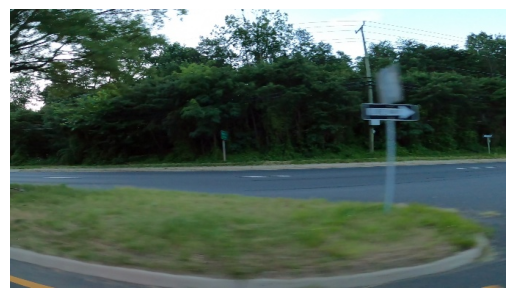

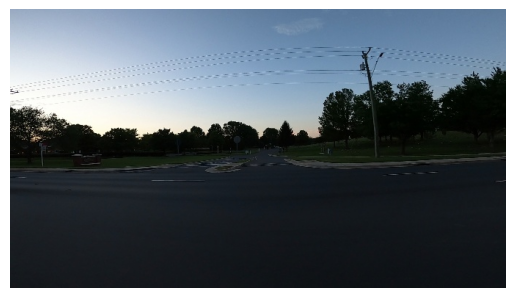

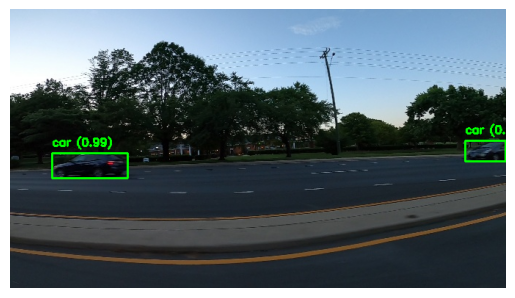

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Darknet'i kullanabilmek için opencv-dnn API'sini kullanacağız
# YOLOv4 modelini yüklemek için gerekli dosyalar
cfg_path = "cfg/yolov4.cfg"   # yolov4.cfg dosyasının yolu
weights_path = "yolov4.weights"  # yolov4.weights dosyasının yolu
class_names_path = "data/coco.names"  # coco.names dosyasının yolu

# YOLO modelini yükleme
net = cv2.dnn.readNet(weights_path, cfg_path)

# sınıf isimlerini yükleme
with open(class_names_path, 'r') as f:
    classes = [line.strip() for line in f.readlines()]

# YOLO'nun çıkış katmanlarını alma
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

# Görüntüdeki nesneleri tespit eden fonksiyon
def detect_objects(image):
    height, width, channels = image.shape
    
    # Görüntüyü YOLO için uygun hale getirme
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)
    
    # Nesne tespiti için verileri işleme
    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:  # güven eşiği
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                
                # Dikdörtgenin koordinatları
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                
                # Verileri ekle
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    # Non-maxima suppression ile kutuları filtreleme
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    
    return boxes, class_ids, indices, confidences

# Görüntü üzerinde nesneleri çizme
def draw_boxes(image, boxes, class_ids, indices, confidences):
    for i in range(len(boxes)):
        if i in indices:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = (0, 255, 0)  # Yeşil renk
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            
            # Güven oranını etiketin yanında göster
            confidence_text = f"{confidences[i]:.2f}"  # Güven oranını 2 ondalıklı göster
            cv2.putText(image, f"{label} ({confidence_text})", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

# Test resimlerini işleme
for image_path in random_test_images:
    image = cv2.imread(image_path)
    boxes, class_ids, indices, confidences = detect_objects(image)
    draw_boxes(image, boxes, class_ids, indices, confidences)

    # Sonuçları matplotlib ile gösterme
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Eksenleri gizle
    plt.show()



# YOLOv4 ile Nesne Tespiti

Bu proje, **YOLOv4** (You Only Look Once) modelini kullanarak nesne tespiti yapmaktadır. YOLOv4, görüntülerdeki nesneleri hızlı ve doğru bir şekilde tespit etmek için kullanılan güçlü bir nesne tespiti modelidir. Bu projede, OpenCV'nin `dnn` modülünü kullanarak YOLOv4 modelini yükleyecek ve test görüntülerinde nesne tespiti gerçekleştireceğiz.

## Gereksinimler

Bu projeyi çalıştırmak için aşağıdaki Python kütüphanelerine ihtiyacınız vardır:

- OpenCV
- Numpy
- Matplotlib

### Kütüphaneleri Yüklemek

Gerekli kütüphaneleri yüklemek için aşağıdaki komutu kullanabilirsiniz:

```bash
pip install opencv-python numpy matplotlib
```

## Proje Yapısı

Proje, aşağıdaki dosya yapısına sahiptir:

```
/darknet
  /cfg
    - yolov4.cfg          # YOLOv4 yapılandırma dosyası
  - yolov4.weights        # YOLOv4 ağırlık dosyası
  - coco.names            # YOLOv4 modelinin tespit edebileceği sınıf isimleri
```

- **`yolov4.cfg`**: YOLOv4 modelinin yapılandırma dosyasının yoludur. Modelin nasıl çalışması gerektiğini tanımlar.
- **`yolov4.weights`**: Modelin eğitim sırasında öğrenilen ağırlıkları içerir.
- **`coco.names`**: Modelin tespit edebileceği sınıf isimlerini içeren dosya (örneğin, araba, insan, kedi).

## Kod Açıklaması

### 1. YOLOv4 Modelini Yüklemek

```python
cfg_path = "cfg/yolov4.cfg"
weights_path = "yolov4.weights"
class_names_path = "data/coco.names"
```

- **`cfg_path`**: YOLOv4 modelinin yapılandırma dosyasının yoludur.
- **`weights_path`**: YOLOv4 modelinin eğitim sırasında elde edilen ağırlıklarının dosya yoludur.
- **`class_names_path`**: Modelin tespit edebileceği nesnelerin sınıf adlarını içeren dosya yoludur.

### 2. Modeli Yüklemek

```python
net = cv2.dnn.readNet(weights_path, cfg_path)
```

- OpenCV'nin `dnn` modülü ile YOLOv4 modelini yükleriz. Ağırlıklar (`weights_path`) ve yapılandırma dosyasından (`cfg_path`) modelin ağırlıklarını ve yapılandırmasını yükleriz.

### 3. Sınıf İsimlerini Yüklemek

```python
with open(class_names_path, 'r') as f:
    classes = [line.strip() for line in f.readlines()]
```

- **`classes`**: `coco.names` dosyasındaki her satır, modelin tespit edebileceği bir sınıfın adını içerir (örneğin, "car", "person", "dog").

### 4. Çıkış Katmanlarını Alma

```python
layer_names = net.getLayerNames()
output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]
```

- YOLO modelinin çıkış katmanları, nesne tespitinin yapılacağı katmanlardır. Bu katmanlar, modelin sonundaki tespit katmanlarıdır.

### 5. Nesne Tespiti Yapmak

```python
def detect_objects(image):
    height, width, channels = image.shape
    
    blob = cv2.dnn.blobFromImage(image, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)
    
    class_ids = []
    confidences = []
    boxes = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)
                w = int(detection[2] * width)
                h = int(detection[3] * height)
                
                x = int(center_x - w / 2)
                y = int(center_y - h / 2)
                
                boxes.append([x, y, w, h])
                confidences.append(float(confidence))
                class_ids.append(class_id)
    
    indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)
    
    return boxes, class_ids, indices, confidences
```

- Bu fonksiyon, her bir görüntü üzerinde nesne tespiti yapar. Görüntüyü modelin beklentilerine uygun hale getirir, sonra modelden çıkan sonuçları işleyerek tespit edilen nesneleri ve kutuları döndürür.

### 6. Nesneleri Görüntü Üzerinde Çizmek

```python
def draw_boxes(image, boxes, class_ids, indices, confidences):
    for i in range(len(boxes)):
        if i in indices:
            x, y, w, h = boxes[i]
            label = str(classes[class_ids[i]])
            color = (0, 255, 0)  # Yeşil renk
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
            
            confidence_text = f"{confidences[i]:.2f}"  # Güven oranını 2 ondalıklı göster
            cv2.putText(image, f"{label} ({confidence_text})", (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
```

- Bu fonksiyon, nesne tespit edilen kutuları görüntü üzerine çizer ve her bir kutunun yanında sınıf ismini ve güven oranını gösterir.

### 7. Sonuçları Görselleştirme

```python
for image_path in random_test_images:
    image = cv2.imread(image_path)
    boxes, class_ids, indices, confidences = detect_objects(image)
    draw_boxes(image, boxes, class_ids, indices, confidences)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Eksenleri gizle
    plt.show()
```

- Test görüntüleri üzerinde nesne tespiti yapılır ve sonuçlar, `matplotlib` kullanılarak görselleştirilir.

## Sonuçlar

Bu projede YOLOv4 modelini kullanarak verilen bir görüntüdeki nesneleri tespit ediyoruz ve her tespit edilen nesnenin etrafına dikdörtgenler çiziyoruz. Ayrıca güven oranını da etiketin yanında görüntülüyoruz.



